In [106]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 6, 1)
date_to = dt.date(2023, 6, 8)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)
players = u.to_players(battles)

### ブキ統計量を求める

- 1分あたりのキル
- 1分あたりのアシスト
- 1分あたりのデス
- 1分あたりのスペシャル
- 1分あたりの塗り面積


In [107]:
result_cols = ["kill", "assist", "death", "special", "inked"]
weapon_stat = players.groupby(["mode", "weapon"])[result_cols + ["time"]].sum()

for col in result_cols:
    weapon_stat[col] = weapon_stat[col] / weapon_stat["time"] * 60

weapon_stat = weapon_stat.drop(columns="time")
weapon_stat = weapon_stat.groupby("weapon").mean()
weapon_stat

,kill,assist,death,special,inked
weapon,,,,,
52gal,1.666097,0.405181,1.654178,0.839690,232.744995
96gal,1.619935,0.392847,1.371195,0.797581,250.895125
96gal_deco,1.595469,0.326058,1.301093,0.708820,223.309205
bamboo14mk1,1.399546,0.588823,1.189630,0.916580,234.036785
barrelspinner,1.107091,0.577710,1.171703,0.913722,258.493141
...,...,...,...,...,...
tristringer,0.956108,0.812819,0.956263,1.047614,237.124900
variableroller,1.413860,0.390259,1.345714,0.966206,295.008822
wakaba,1.195106,0.478042,1.329569,0.912337,296.006554


### 相関係数を確認する

In [108]:
weapon_stat.corr()

,kill,assist,death,special,inked
kill,1.000000,-0.378675,0.617903,-0.493727,-0.420152
assist,-0.378675,1.000000,-0.150110,0.266457,0.142801
death,0.617903,-0.150110,1.000000,-0.432211,-0.260926
special,-0.493727,0.266457,-0.432211,1.000000,0.866630
inked,-0.420152,0.142801,-0.260926,0.866630,1.000000


### 主成分分析を行う

In [109]:
from sklearn.decomposition import PCA

def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()

df = weapon_stat.reset_index()
df_z = df.iloc[:,1:].apply(standardize)
dimension = len(df_z.columns)
pc_cols = [f"pc{x+1}" for x in range(dimension)]

pca = PCA()
pca.fit(df_z)

# 各ブキの主成分を求める
score = pd.DataFrame(pca.transform(df_z), columns=pc_cols)
score = pd.concat([df.iloc[:,:1], score], axis=1)
score = score.set_index("weapon")

# 累積寄与率 cc_ratio を求める
ev_ratio = pd.DataFrame(pca.explained_variance_ratio_, index=pc_cols)
cc_ratio = ev_ratio.cumsum().T

# 主成分負荷量 eigen_vector を求める
eigen_vector = pd.DataFrame(pca.components_, columns=df_z.columns, index=pc_cols)

cc_ratio

,pc1,pc2,pc3,pc4,pc5
0,0.538702,0.740962,0.911489,0.979439,1.0


### 可視化する

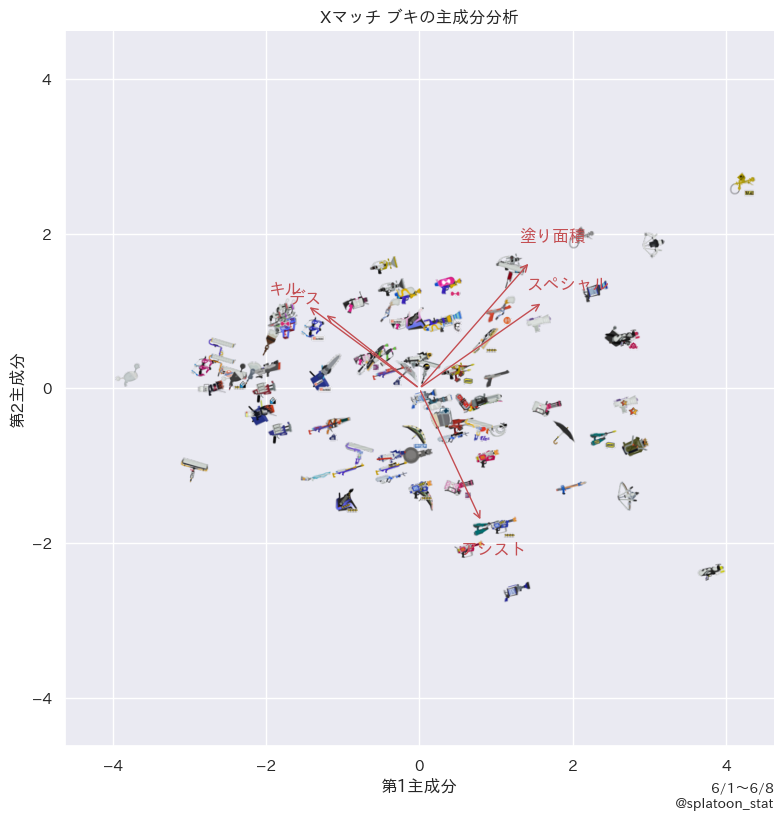

In [110]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("title", "${lobby} ブキの主成分分析", "Weapon PCA in ${lobby}")
i18n.add("pc1", "第1主成分", "1st component")
i18n.add("pc2", "第2主成分", "2nd component")
i18n.add("kill", "キル", "Kill")
i18n.add("assist", "アシスト", "Assist")
i18n.add("death", "デス", "Death")
i18n.add("special", "スペシャル", "Special")
i18n.add("inked", "塗り面積", "Inked")

value_range = max(score[["pc1", "pc2"]].abs().max().max() * 1.1, 3)

g = sns.relplot(
    data=score,
    x="pc1",
    y="pc2",
    marker="",
    height=8,
)
ax = g.ax

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel=i18n.t("pc1"),
    ylabel=i18n.t("pc2"),
    xlim=(-value_range, value_range),
    ylim=(-value_range, value_range),
)

for i, row in score.iterrows():
    weapon = row.name
    xvalue = row["pc1"]
    yvalue = row["pc2"]
    image_path = image.get_image_path(weapon)
    im = plt.imread(image_path)
    img = OffsetImage(im, zoom=0.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
    ax.add_artist(ab)

for col, item in eigen_vector.items():
    mag = 3
    vec = [item["pc1"], item["pc2"]]
    ax.annotate("", (0, 0), xytext=[x * mag for x in vec], color="r", arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color="r"))
    ax.annotate(i18n.t(col), (0, 0), xytext=[x * mag * 1.2 for x in vec], color="r", ha="center", va="center")

u.credit(ax, g.fig, i18n.t_data_duration(battles))
plt.show()


In [111]:
score

,pc1,pc2,pc3,pc4,pc5
weapon,,,,,
52gal,-0.833727,1.106813,-0.232375,-0.173743,-0.446293
96gal,-0.191376,0.867173,0.520909,-0.580458,0.210935
96gal_deco,-0.682794,0.392627,1.129028,-0.546941,0.103491
bamboo14mk1,0.877504,-0.191106,0.449084,-0.797965,-0.307775
barrelspinner,1.672597,-0.231833,0.630779,0.016221,-0.009894
...,...,...,...,...,...
tristringer,2.719174,-1.387943,0.471820,-0.536189,-0.577059
variableroller,1.179180,1.488054,0.432725,-0.188702,0.247644
wakaba,1.559306,0.860269,0.350744,0.328778,0.437621
